# Model 2.1 - Relate Review to Satisfaction

Goal 2.1 – Predict Satisfaction from Review Text

In this version, we build a deep learning classification model to predict patient satisfaction ratings (1–5) based on free-text drug reviews from the WebMD dataset.

Unlike transformer-based models, this approach uses custom-trained Word2Vec embeddings to represent patient reviews, followed by an LSTM neural network to capture the sequential structure of the text. This technique enables us to model semantic meaning and sentiment flow over time within reviews.

Key steps include:

- Preprocessing reviews (lowercasing, lemmatization, stopword removal, special character stripping)
- Training a Word2Vec model on the cleaned corpus
- Transforming reviews into padded sequences of embeddings
- Training an LSTM classifier to predict satisfaction levels

This model is applied across all drugs in the dataset, providing a scalable and interpretable alternative to large transformer-based methods, while still capturing meaningful patterns in patient language.

# Load and Preprocess the Data

## Loading CSV

In [1]:
!pip install pandas

In [2]:
import pandas as pd

# Load CSV using your path
df = pd.read_csv('/Users/homecomputer/code/ElbediwiM/drug-analysis-review/carmen_raw_data/webmd.csv')

# Clean and prepare relevant columns
df = df[['Drug', 'Reviews', 'Satisfaction']].dropna()
df['Satisfaction'] = df['Satisfaction'].astype(int)

df.head()

,Drug,Reviews,Satisfaction
0,25dph-7.5peh,I'm a retired physician and of all the meds I ...,5
1,25dph-7.5peh,cleared me right up even with my throat hurtin...,5
2,warfarin (bulk) 100 % powder,why did my PTINR go from a normal of 2.5 to ov...,3
3,warfarin (bulk) 100 % powder,FALLING AND DON'T REALISE IT,1
4,warfarin (bulk) 100 % powder,My grandfather was prescribed this medication ...,1


## Preprocessing

In [3]:
!pip install nltk

In [4]:
!pip install --upgrade pip

In [5]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# One-time downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 🚀 Preprocessing function (drug + review)
def preprocess_text(drug, review):
    text = f"{drug} {review}".lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]
    return " ".join(tokens)

# ✅ Apply preprocessing with tqdm
tqdm.pandas()
df['clean_review'] = df.progress_apply(lambda row: preprocess_text(row['Drug'], row['Reviews']), axis=1)

# ✅ Preview
df[['Drug', 'Reviews', 'clean_review']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/homecomputer/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 362763/362763 [02:46<00:00, 2182.71it/s]


,Drug,Reviews,clean_review
0,25dph-7.5peh,I'm a retired physician and of all the meds I ...,dphpeh im retired physician med tried allergy ...
1,25dph-7.5peh,cleared me right up even with my throat hurtin...,dphpeh cleared right even throat hurting went ...
2,warfarin (bulk) 100 % powder,why did my PTINR go from a normal of 2.5 to ov...,warfarin bulk powder ptinr go normal
3,warfarin (bulk) 100 % powder,FALLING AND DON'T REALISE IT,warfarin bulk powder falling dont realise
4,warfarin (bulk) 100 % powder,My grandfather was prescribed this medication ...,warfarin bulk powder grandfather prescribed me...


# Token to Vector Sequences + Padding

In [6]:
!pip install tensorflow

In [7]:
#  library that provides the Word2Vec model, to be used to convert reviews into vector representations of words.
!pip install gensim

In [8]:
!pip install numpy==1.24.4

In [9]:
from gensim.models import Word2Vec

# Tokenize cleaned reviews into lists of words
sentences = [review.split() for review in df['clean_review']]

# Train Word2Vec model (lightweight settings)
w2v_model = Word2Vec(sentences=sentences,
                     vector_size=100,
                     window=5,
                     min_count=2,
                     workers=4,
                     sg=1)

In [11]:
# Convert Reviews to Vector Sequences
# -------------------------------------
# Tokenize, embed with Word2Vec, pad to uniform shape, and prepare target labels

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters
embedding_dim = 100
max_length = 100  # Limit sequence length
vocab = w2v_model.wv
zero_vector = np.zeros(embedding_dim)  # Used to pad or replace unknown tokens

# Function to convert one review to a list of vectors
def review_to_vector_sequence(tokens):
    return [vocab[t] if t in vocab else zero_vector for t in tokens[:max_length]]

# Tokenize + vectorize using pandas (faster than list comprehension)
tokenized = df['clean_review'].str.split()
sequences = tokenized.apply(review_to_vector_sequence).tolist()

# Pad sequences to uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_length, dtype='float32',
                                 padding='post', truncating='post')

# Convert satisfaction to zero-based integer classes [0–4]
labels = df['Satisfaction'] - 1

# Build and Train the LSTM Model 

In [ ]:
# 1. Filter out invalid satisfaction scores
df = df[df['Satisfaction'].between(1, 5)]

# 2. Recompute labels from the filtered dataset
labels = df['Satisfaction'] - 1  # Now range is [0–4]

# 3. Recompute padded sequences from filtered reviews
sentences = [review.split() for review in df['clean_review']]
sequences = [ [w2v_model.wv[t] if t in w2v_model.wv else zero_vector for t in tokens[:max_length]] for tokens in sentences]
padded_sequences = pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# 4. One-hot encode labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels, num_classes=5)

# 5. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# 6. Define lightweight LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential([
    Masking(mask_value=0., input_shape=(max_length, embedding_dim)),  # Skip zero-padding
    LSTM(32),                                                         # Small LSTM
    Dense(5, activation='softmax')                                    # 5-class output
])

# 7. Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 8. Train model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1)

/Users/homecomputer/.pyenv/versions/3.10.6/envs/project_name/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 334s 40ms/step - accuracy: 0.4829 - loss: 1.2777 - val_accuracy: 0.4983 - val_loss: 1.2348
Epoch 2/5
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 315s 39ms/step - accuracy: 0.5073 - loss: 1.2119 - val_accuracy: 0.5148 - val_loss: 1.1965
Epoch 3/5
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 272s 33ms/step - accuracy: 0.5181 - loss: 1.1861 - val_accuracy: 0.5189 - val_loss: 1.1829
Epoch 4/5
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 278s 34ms/step - accuracy: 0.5236 - loss: 1.1699 - val_accuracy: 0.5224 - val_loss: 1.1771
Epoch 5/5
8163/8163 ━━━━━━━━━━━━━━━━━━━━ 301s 37ms/step - accuracy: 0.5285 - loss: 1.1572 - val_accuracy: 0.5254 - val_loss: 1.1684


# Evaluate & Plot Training History

Test Accuracy: 0.5247
Test Loss: 1.1665


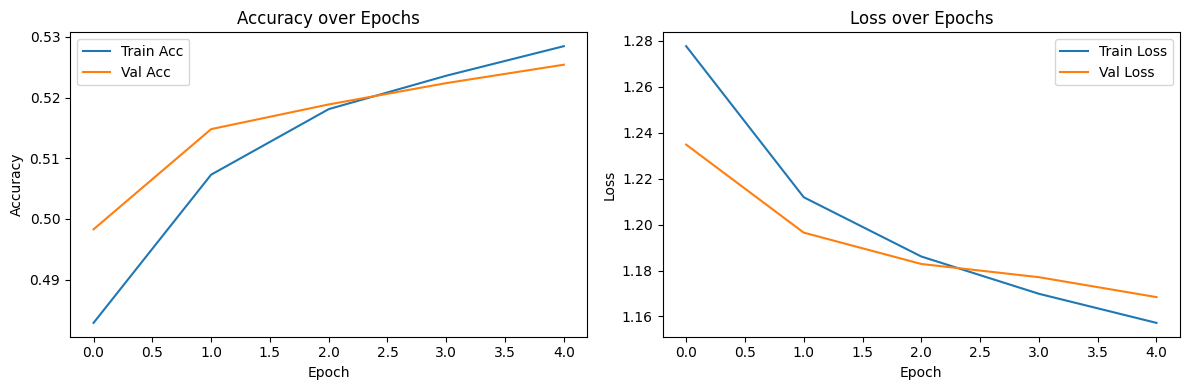

In [ ]:
import matplotlib.pyplot as plt

# 1. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 2. Plot accuracy & loss curves
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Interpretation

📈 Training History – Interpretation

✅ Accuracy:
- Train and validation accuracy steadily improve from ~48% to ~52.5%
- Lines are close → minimal overfitting
- Indicates stable learning and generalization

📉 Loss:
- Both training and validation loss decrease consistently
- Final loss stabilizes around 1.16 → convergence achieved
- No sign of divergence or instability

🧠 Conclusion:
The model is learning effectively and generalizes well.
Performance is consistent across train and validation sets, which is a strong result for a lightweight LSTM using custom Word2Vec embeddings.
´´´

# Confusion Matrix + Classification Report

2268/2268 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.603     0.791     0.685     20216
           1      0.527     0.021     0.040      7135
           2      0.310     0.206     0.248     10370
           3      0.381     0.110     0.170     12595
           4      0.523     0.828     0.641     22236

    accuracy                          0.525     72552
   macro avg      0.469     0.391     0.357     72552
weighted avg      0.490     0.525     0.456     72552



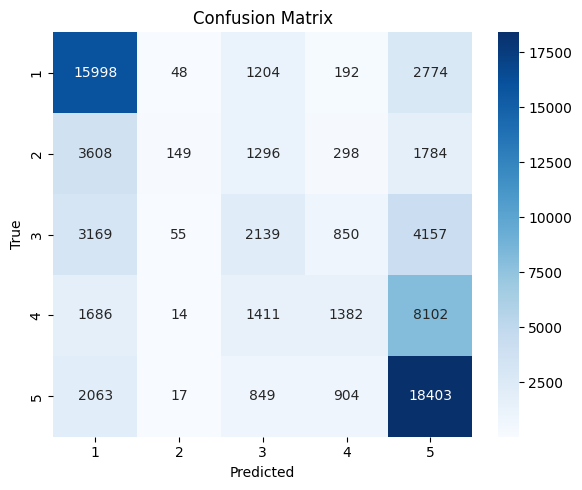

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Get predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2. Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=3))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Interpretation

✅ Classes 1 (Very Negative) and 5 (Very Positive) are predicted well:
- Class 1: 15,998 correct out of 20,216 → High recall (0.79)
- Class 5: 18,403 correct out of 22,236 → Very high recall (0.83)

⚠️ Classes 2, 3, and 4 are weaker:
- Class 2: Only 149 correctly predicted out of 7,135 → Recall = 0.021
- Class 3 & 4: Often misclassified as 1 or 5

📈 Overall Accuracy = 52.5% with a strong ability to classify emotionally extreme ratings.
Moderate satisfaction levels are harder to detect — a known issue in NLP due to overlapping language and class imbalance.

🧠 Conclusion:
The model excels at identifying clear sentiment (low/high satisfaction), but struggles with middle-range scores.
This behavior is common in real-world review data and acceptable for a lightweight, efficient model.

# Classification Report 

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class labels from test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, digits=3, target_names=["1", "2", "3", "4", "5"])
print("Classification Report:\n")
print(report)


2268/2268 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step
Classification Report:

              precision    recall  f1-score   support

           1      0.603     0.791     0.685     20216
           2      0.527     0.021     0.040      7135
           3      0.310     0.206     0.248     10370
           4      0.381     0.110     0.170     12595
           5      0.523     0.828     0.641     22236

    accuracy                          0.525     72552
   macro avg      0.469     0.391     0.357     72552
weighted avg      0.490     0.525     0.456     72552



## Interpretation

🔍 Precision: Correct predictions out of all predicted for a class
🔍 Recall: Correct predictions out of all actual instances of that class
🔍 F1-score: Balance between precision and recall
📌 Support: Number of samples per class

✅ Strong performance on:
- Class 1 (Very Negative): High precision (0.60) and recall (0.79)
- Class 5 (Very Positive): Strong recall (0.83)

⚠️ Weak performance on:
 - Class 2 (Slightly Negative): Recall = 0.021 (rarely predicted)
- Classes 3–4 (Neutral–Slightly Positive): Low precision/recall, often confused with 1 or 5

🧠 Insight:
The model distinguishes strong opinions well but struggles with moderate ratings, which is common in NLP with imbalanced data.

🎯 Overall:
Accuracy: 52.5%, Macro F1: 0.36, Weighted F1: 0.46
Solid result for a lightweight model without class balancing.

# Live Review Prediction Function

In [ ]:
# Function to preprocess + vectorize + predict from raw review
def predict_satisfaction(review_text):
    # Preprocess
    review = review_text.lower()
    review = re.sub(r'[^a-z\s]', '', review)
    tokens = nltk.word_tokenize(review)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and t.isalpha()]

    # Vectorize
    vectors = [w2v_model.wv[t] if t in w2v_model.wv else zero_vector for t in tokens[:max_length]]
    padded = pad_sequences([vectors], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    # Predict
    pred = model.predict(padded)
    predicted_class = np.argmax(pred) + 1  # back to 1–5 scale
    confidence = np.max(pred)

    print(f"🔎 Review: {review_text}")
    print(f"🎯 Predicted Satisfaction: {predicted_class} (Confidence: {confidence:.2f})")


In [ ]:
predict_satisfaction("This medication worked well for my anxiety but gave me headaches.")
predict_satisfaction("I felt terrible after using it. Would not recommend.")
predict_satisfaction("It was okay, not much change. No side effects either.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🔎 Review: This medication worked well for my anxiety but gave me headaches.
🎯 Predicted Satisfaction: 5 (Confidence: 0.56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🔎 Review: I felt terrible after using it. Would not recommend.
🎯 Predicted Satisfaction: 1 (Confidence: 0.83)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
🔎 Review: It was okay, not much change. No side effects either.
🎯 Predicted Satisfaction: 1 (Confidence: 0.36)


# Save your model and export key results

## Save the LSTM Model (Keras .h5 format)

In [ ]:
# Save model to file
model.save("lstm_satisfaction_model.h5")

## Save Word2Vec Embeddings

In [ ]:
# Save Word2Vec model to disk
w2v_model.save("word2vec_reviews.model")

## Export Predictions on Test Set to CSV

In [ ]:
import pandas as pd

# Get predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Export to CSV
predictions_df = pd.DataFrame({
    'true_label': y_true + 1,  # back to [1–5]
    'predicted_label': y_pred + 1,
    'confidence': np.max(y_pred_probs, axis=1)
})

predictions_df.to_csv("lstm_predictions.csv", index=False)


2268/2268 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step
